In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.regressor import residuals_plot
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from feature_engine.encoding import OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.metrics import mean_squared_error

In [2]:
pd.set_option("display.max_columns", 99)
df = pd.read_csv("../data/mergeB_for_modeling.csv")
df.head(n=3)

# Title case the feature for better display and create the visualizer
labels = list(map(lambda s: s.title(), df.columns.tolist()))
df.columns = labels

# New Feature Creation

In [3]:
# Create features by dividing one column by another or subtracting one column from another.

df["Teacher_Ratio1"] = df.Teachers_Fte / df.Enrollment
df["Teacher_Ratio2"] = df.Teachers_Fte / df.All_Cohort_
df["Num_Grades"] = df.Highest_Grade_Offered - df.Lowest_Grade_Offered


In [4]:
df.dtypes

Year                             int64
Stnam                           object
Fipst                            int64
Leaid                            int64
Leanm                           object
Ncessch                          int64
Schnam                          object
All_Cohort_                      int64
School_Name                     object
Zip_Mailing                    float64
Zip_Location                   float64
Latitude                       float64
Urban_Centric_Locale           float64
County_Code                    float64
School_Level                   float64
School_Type                    float64
Lowest_Grade_Offered           float64
Highest_Grade_Offered          float64
Title_I_Status                 float64
Title_I_Eligible               float64
Charter                        float64
Magnet                         float64
Virtual                        float64
Teachers_Fte                   float64
Free_Lunch                     float64
Reduced_Price_Lunch      

# Prepare dataframes and train-test split for modeling

In [5]:
def Make_X_y(df : pd.DataFrame):
    """
    # Subset to features used in modeling. 
    # Tag categoricals to the pandas type categorical. 
    """

    X = df.copy()

    X.drop(
        [
            "Stnam",
            "Leanm",
            "Ncessch",
            "Schnam",
            "School_Name",
            "Zip_Mailing",
            "Leaid",
            "Zip_Location",
            "County_Code",
            "Fipst",
            "Area_Name",
            "Year",
        ],
        inplace=True,
        axis=1,
    )


    y = X.pop("All_Rate_")

    # Tag categoricals so that they can be treated properly by the modeling packages
    categoricals =['Urban_Centric_Locale', 'School_Level', 'School_Type', 'Title_I_Status', 'Title_I_Eligible', 'Charter', 'Magnet', 'Virtual', 'Ungrade_Cedp', 'Rural_Urban_Continuum_Code', 'Urban_Influence_Code', 'Metro_Or_Not']

    # Convert categoricals to the pandas type 'category'
    for col in categoricals:
        X[col] = X[col].astype("category")

    # Create train-test split
    Xtrain, Xtest, ytrain, ytest = train_test_split(
        X, y, test_size=0.30, stratify=y, random_state=42
    )
    return X, y, Xtrain, Xtest, ytrain, ytest



In [6]:
X, y, Xtrain, Xtest, ytrain, ytest = Make_X_y(df)
pd.set_option("display.max_rows", 999)
X.dtypes

All_Cohort_                       int64
Latitude                        float64
Urban_Centric_Locale           category
School_Level                   category
School_Type                    category
Lowest_Grade_Offered            float64
Highest_Grade_Offered           float64
Title_I_Status                 category
Title_I_Eligible               category
Charter                        category
Magnet                         category
Virtual                        category
Teachers_Fte                    float64
Free_Lunch                      float64
Reduced_Price_Lunch             float64
Free_Or_Reduced_Price_Lunch     float64
Enrollment                      float64
Ungrade_Cedp                   category
Math_Pct_Part                   float64
Rla_Pct_Part                    float64
Rural_Urban_Continuum_Code     category
Urban_Influence_Code           category
Metro_Or_Not                   category
Civilian_Labor_Force            float64
Unemployment_Rate               float64


In [7]:
Xtrain.head(n=2)


,All_Cohort_,Latitude,Urban_Centric_Locale,School_Level,School_Type,Lowest_Grade_Offered,Highest_Grade_Offered,Title_I_Status,Title_I_Eligible,Charter,Magnet,Virtual,Teachers_Fte,Free_Lunch,Reduced_Price_Lunch,Free_Or_Reduced_Price_Lunch,Enrollment,Ungrade_Cedp,Math_Pct_Part,Rla_Pct_Part,Rural_Urban_Continuum_Code,Urban_Influence_Code,Metro_Or_Not,Civilian_Labor_Force,Unemployment_Rate,Teacher_Ratio1,Teacher_Ratio2,Num_Grades
28263,18,39.80761,43.0,3.0,1.0,7.0,12.0,1.0,1.0,0.0,0.0,0.0,18.000000,58.0,21.0,79.0,146.0,0.0,90.0,90.0,9.0,12.0,0.0,1518.0,2.4,0.123288,1.00000,5.0
12172,40,35.35770,42.0,3.0,1.0,7.0,12.0,5.0,1.0,0.0,0.0,0.0,32.709999,130.0,49.0,179.0,277.0,0.0,97.5,95.0,4.0,5.0,0.0,35304.0,7.6,0.118087,0.81775,5.0


# Hyper-parameter tuning of RandomForest models 

In [8]:
# Create and run hyperparameter tuning pipeline
from sklearn.model_selection import GridSearchCV
import warnings
import joblib
import os

warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
param_grid = {
    "rf__n_estimators": [500],
    "rf__max_features": [55,60,65],
    "rf__max_depth": [90, 100],
    "rf__ccp_alpha": [0.0],
    "rf__random_state": [42],
}
pipe = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(drop_last=True, variables=Xtrain.select_dtypes(include='category').columns.tolist())),
        ("rf", RandomForestRegressor()),
    ]
)

# Load model from disk instead of running again.
clf = {}
local_model_path = (
    "../../student_outcome_saved_models/model_datasetB_random_forest_gridsearch2.pkl"
)
if os.path.exists(local_model_path):
    clf = joblib.load(local_model_path)
else:
    clf = GridSearchCV(
        pipe,
        param_grid,
        n_jobs=4,
        verbose=3,
        cv=4,
        scoring="r2",
    )
    clf.fit(Xtrain, ytrain)
    joblib.dump(clf, local_model_path)

del clf

## Best parameters from GridSearch
    * First round: {'rf__ccp_alpha': 0.0, 'rf__max_depth': 100, 'rf__max_features': 60, 'rf__n_estimators': 500, 'rf__random_state': 42}
    * Second round: {'rf__ccp_alpha': 0.0, 'rf__max_depth': 90, 'rf__max_features': 55, 'rf__n_estimators': 500, 'rf__random_state': 42}

# Convert To Classification Problem

Bins: [84.5 92. ]


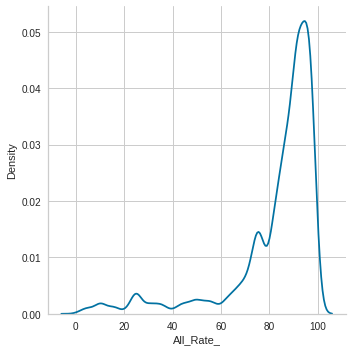

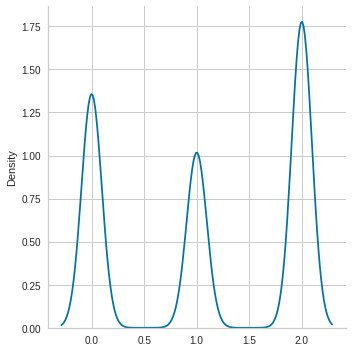

In [9]:
bins = np.percentile(ytrain,[33,66])
ytrain_binned = np.digitize(ytrain,bins=bins) 
ytest_binned = np.digitize(ytest,bins=bins) 
print("Bins:", bins)
sns.displot(ytrain,kind='kde',label="continuous")
sns.displot(ytrain_binned,kind='kde',label="33,66 bins")


# Perform Classification with 3 Classes

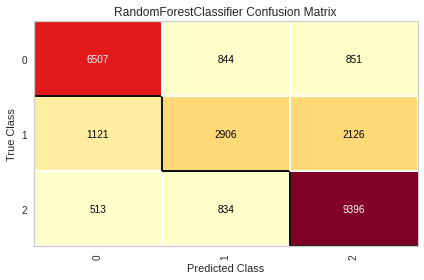

0.7494222647222887


In [10]:
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.classifier import ConfusionMatrix

pipe = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(drop_last=True, variables=Xtrain.select_dtypes(include='category').columns.tolist())),
        (
            "rf",
            RandomForestClassifier(
                n_jobs=2,
                max_features=55,
                n_estimators=500,
                max_depth=90,
                random_state=42,
            ),
        ),
    ]
)
conf = ConfusionMatrix(pipe,classes=(0,1,2))
conf.fit(Xtrain,ytrain_binned)

conf.score(Xtest,ytest_binned)
conf.show()
print(conf.score_)

# Perform classification with 2 classes

Bins: [90.]


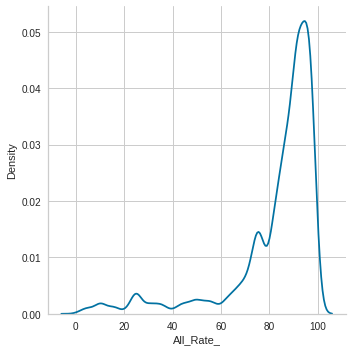

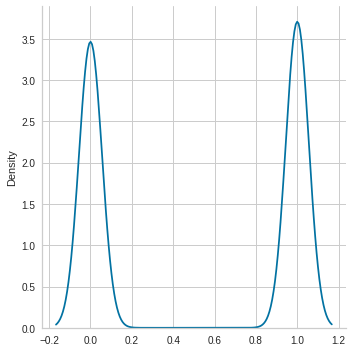

In [ ]:
bins = np.percentile(ytrain,[50])
ytrain_binned = np.digitize(ytrain,bins=bins) 
ytest_binned = np.digitize(ytest,bins=bins) 
y_binned = np.digitize(y,bins=bins)
print("Bins:", bins)
sns.displot(ytrain,kind='kde',label="continuous")
sns.displot(ytrain_binned,kind='kde')

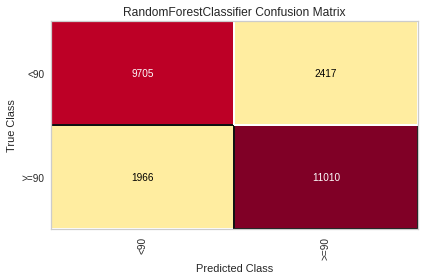

0.825364570882142


In [13]:
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.classifier import ConfusionMatrix

pipe = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(drop_last=True, variables=Xtrain.select_dtypes(include='category').columns.tolist())),
        (
            "rf",
            RandomForestClassifier(
                n_jobs=4,
                max_features=55,
                n_estimators=500,
                max_depth=90,
                random_state=42,
            ),
        ),
    ]
)
conf = ConfusionMatrix(pipe,classes=("<90",">=90"))
conf.fit(Xtrain,ytrain_binned)

conf.score(Xtest,ytest_binned)
conf.show()
print(conf.score_)

# Test an SVM model on the 2 class problem

In [14]:
from sklearn.svm import SVC
from yellowbrick.classifier import ConfusionMatrix

scaler = SklearnTransformerWrapper(transformer=StandardScaler(), variables=Xtrain.select_dtypes(include=np.number).columns.tolist())

pipe = Pipeline(
    steps=[
        ("scaler", scaler),
        ("onehot", OneHotEncoder(drop_last=True, variables=Xtrain.select_dtypes(include='category').columns.tolist())),
        (
            "rf",
            SVC(
                C=1,
                kernel="rbf",
                random_state=42,
            ),
        ),
    ]
)
conf = ConfusionMatrix(pipe,classes=("<90",">=90"))
conf.fit(Xtrain,ytrain_binned)

conf.score(Xtest,ytest_binned)
conf.show()
print(conf.score_)

# SVC C=1, kernel=poly score=0.777
# SVC C=1, kernel=rbf score=0.78

KeyboardInterrupt: 

# Recursive Feature Elimination

In [152]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import KFold 
import joblib
import os
from yellowbrick.model_selection import rfecv
#  recursive_feature_elimination1 - decisiontreeregressor, max_depth 100, took 156 minutes, peaked at 2 features, 0.596
#  recursive_feature_elimination2 - decisiontreeclassifier, default params, took 105 minutes, peaked at 54 features, 0.641
#  recursive_feature_elimination3 - decisiontreeclassifier with whole X, cv 3, max_features 55, max depth 90, took 5 minutes, peaked at 7   features,  
#  recursive_feature_elimination3 - decisiontreeclassifier with whole X, cv 5, default params, took 5 minutes, peaked at 7 features,  
cv = KFold(3)

onehotter = OneHotEncoder(drop_last=True,variables=X.select_dtypes(include='category').columns.tolist())
X_onehotted = onehotter.fit_transform(X)
print("Number of features in X_onehotted", X.shape)

# Load visualizer from disk instead of running again.
visualizer = {}
local_file = (
    "../../student_outcome_saved_models/recursive_feature_elimination4.pkl"
)
if os.path.exists(local_file):
    visualizer = joblib.load(local_file)
else:
    visualizer = rfecv(DecisionTreeClassifier(max_features=55,max_depth=90),step=2, X=X, y=y_binned, cv=cv,scoring='f1_weighted')
    joblib.dump(visualizer, local_file)


Number of features in X_onehotted (83658, 28)


# Remove unhelpful features

(28, 69)

In [ ]:
# Print out best parameters
print(clf.best_params_)
clf.cv_results_
del clf


In [ ]:
clf.best_estimator_

# Reduce number of features
* Reduces modeling time
* Improves interpretability
* Prevents overfitting to create a more general model

In [ ]:
# Combine top X features from RandomForest and Polynomial Lasso
df.columns = labels = list(map(lambda s: s.title(), df.columns.tolist()))

top_features_rf = list(dict(sorted(list(zip(viz_rf.feature_importances_,viz_rf.features_)),reverse=True)).values())
top_features_rf

features_to_drop = []
for col in df.columns:
    if col not in " ".join(top_features_rf):
        features_to_drop += [col]
features_to_drop.remove("All_Rate_")
features_to_drop.remove("Year")
features_to_drop.remove("Ncessch")
features_to_drop.remove("Schnam")
print("Features dropped:",features_to_drop)
df.drop(features_to_drop,inplace=True,axis=1)
df.columns

# Feature Visualization 

In [ ]:
# Rad viz using equal sized blocked
# Rad viz using percentile


from yellowbrick.features import Rank2D
from yellowbrick.features import RadViz
from yellowbrick.features import ParallelCoordinates

visualizer = Rank2D(algorithm='covariance', features=(X).columns.tolist(), size=(1080, 720))
visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()

visualizer = RadViz(classes=None,alpha=0.5, features=features, size=(1080, 720))
visualizer.fit(Xtrain[features], ytrain_classes)
visualizer.transform(Xtrain[features])
visualizer.show()

In [ ]:
df.to_csv("../data/mergeB_for_modeling_features_engineered.csv", index=False)